In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import glob
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [110]:
base_dir = './'

train_dir = os.path.join(base_dir, 'hymenotera_data/train/')
valid_dir = os.path.join(base_dir, 'hymenotera_data/val/')

# 훈련에 사용되는 개미, 벌 이미지 경로

train_ants_dir = os.path.join(train_dir,'ants/')
train_bees_dir = os.path.join(train_dir,'bees/')

# 테스트에 사용되는 개비, 벌 이미지 경로

val_ants_dir = os.path.join(valid_dir,'ants/')
val_bees_dir = os.path.join(valid_dir,'bees/')

In [111]:
train_dir

'./hymenotera_data/train/'

In [112]:
print('Total training ants images :', len(os.listdir(train_ants_dir)))
print('Total training bees images :', len(os.listdir(train_bees_dir)))

print('Total validation ants images :', len(os.listdir(val_ants_dir)))
print('Total validation bees images :', len(os.listdir(val_bees_dir)))

Total training ants images : 124
Total training bees images : 121
Total validation ants images : 70
Total validation bees images : 83


In [113]:
glob.glob(train_ants_dir+'*')[:10]

['./hymenotera_data/train/ants\\0013035.jpg',
 './hymenotera_data/train/ants\\1030023514_aad5c608f9.jpg',
 './hymenotera_data/train/ants\\1095476100_3906d8afde.jpg',
 './hymenotera_data/train/ants\\1099452230_d1949d3250.jpg',
 './hymenotera_data/train/ants\\116570827_e9c126745d.jpg',
 './hymenotera_data/train/ants\\1225872729_6f0856588f.jpg',
 './hymenotera_data/train/ants\\1262877379_64fcada201.jpg',
 './hymenotera_data/train/ants\\1269756697_0bce92cdab.jpg',
 './hymenotera_data/train/ants\\1286984635_5119e80de1.jpg',
 './hymenotera_data/train/ants\\132478121_2a430adea2.jpg']

In [133]:
# 이미지 전처리 
trans = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

val_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
trainset = torchvision.datasets.ImageFolder(root=train_dir,transform=trans)
validset = torchvision.datasets.ImageFolder(root=valid_dir, transform=val_trans)

In [134]:
#train image 개수 
len(trainset)

244

In [135]:
# 폴더명이 클래스로 지정됨 
classes = trainset.classes
classes

['ants', 'bees']

In [136]:
train_loader =  torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

In [137]:
test_loader = torch.utils.data.DataLoader(validset, batch_size=8, shuffle=True)

In [138]:
images, labels = next(iter(train_loader))

In [139]:
images.shape, labels.shape 

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

### 데이터 시각화

In [140]:
labels_map = {v:k for k, v in trainset.class_to_idx.items()}

In [141]:
labels_map

{0: 'ants', 1: 'bees'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

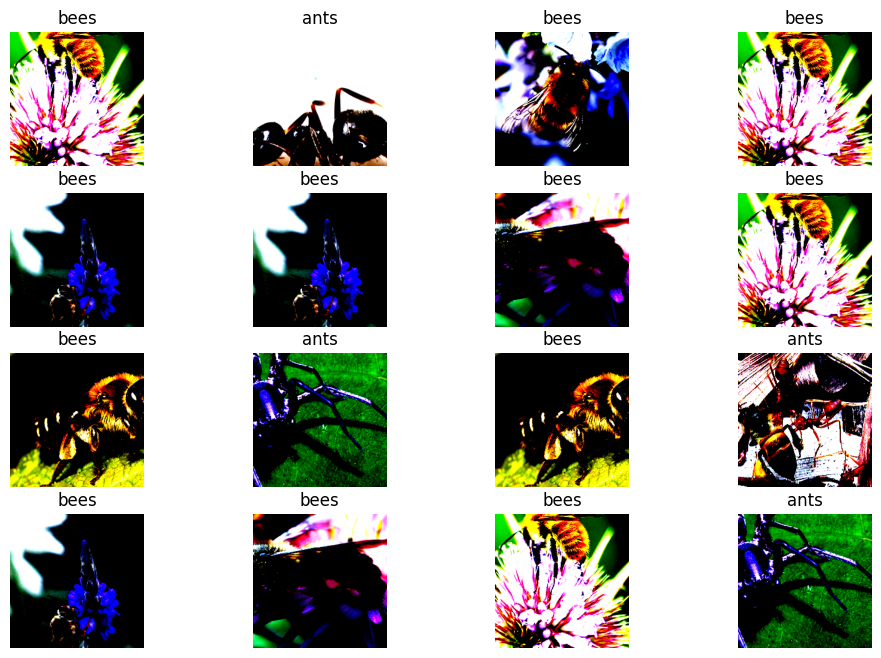

In [142]:
fig = plt.figure(figsize=(12,8))
col, row = 4, 4

for i in range(1, col * row + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    fig.add_subplot(row, col, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [149]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(576, 1000)
        self.fc2 = nn.Linear(1000,1)
        
    def forward(self, x):
        # 
        out = F.relu(self.layer1(x))
        #print(x.size())
        out = F.relu(self.layer2(out))
        #print(out.size())
        out = F.relu(self.layer3(out))
        #print(out.size())
        
        
        out = out.view(out.size(0), -1) # 차원 축소 
        #print(out.size())
        out = self.drop_out(out)
        #print(out.size())
        out = F.relu(self.fc1(out))
        #print("fc1 : ", out.size())
        out = self.fc2(out)
        #print(out.size())
        return out

mo = Model()
output = mo(torch.randn(8, 3, 224, 224))
    

In [150]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc*100)
    
    return acc

In [151]:
EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.1

In [152]:
model = Model()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [153]:
for e in range( 1, EPOCHS + 1 ):
    epoch_loss = 0
    epoch_acc =0 
    # data 를 GPU 로 전달해줌 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.FloatTensor)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    print(f'Epoch {e+0:03}: | Loss {epoch_loss/len(train_loader):.5f} | Acc : {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss 30.48318 | Acc : 45.548
Epoch 002: | Loss 1.65438 | Acc : 50.000
Epoch 003: | Loss 1.37497 | Acc : 49.968
Epoch 004: | Loss 0.70971 | Acc : 44.677
Epoch 005: | Loss 0.69566 | Acc : 48.710
Epoch 006: | Loss 0.69970 | Acc : 49.613
Epoch 007: | Loss 0.69847 | Acc : 52.419
Epoch 008: | Loss 0.70026 | Acc : 50.742
Epoch 009: | Loss 0.69954 | Acc : 51.258
Epoch 010: | Loss 0.70274 | Acc : 49.968
Epoch 011: | Loss 0.69813 | Acc : 48.065
Epoch 012: | Loss 0.69814 | Acc : 50.000
Epoch 013: | Loss 0.69666 | Acc : 50.806
Epoch 014: | Loss 0.69857 | Acc : 49.548
Epoch 015: | Loss 0.70048 | Acc : 49.226
Epoch 016: | Loss 0.69770 | Acc : 49.645
Epoch 017: | Loss 0.69435 | Acc : 48.000
Epoch 018: | Loss 0.69592 | Acc : 49.581
Epoch 019: | Loss 0.69696 | Acc : 50.387
Epoch 020: | Loss 0.69546 | Acc : 47.290
Epoch 021: | Loss 0.69599 | Acc : 45.484
Epoch 022: | Loss 0.69529 | Acc : 50.452
Epoch 023: | Loss 0.69471 | Acc : 46.290
Epoch 024: | Loss 0.69478 | Acc : 48.806
Epoch 025: | Lo

### Transfer learning
- 기존에 학습된 파라미터를 새로운 문제에 "전이" 시키도록 학습
- 사전에 학습된 모델인 "pre-trained Model"을 나의 프로젝트에 맞게 재정의 하려면 원래 모델에 있던 classifier 를 없애야함.
- 그리고 내 목적에 맞는 새로운 classifier를 추가한다. 
- 마지막으로 새롭게 만든 모델을 파인튜닝한다. 

In [154]:
import torch
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg16(pretrained=True).to(device)

print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [155]:
from torchsummary import summary
summary(vgg, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [156]:
for name, layer in vgg.named_modules():
    print(name, layer)

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [168]:
vgg.fc = torch.nn.Linear(1000,1) # 새로운 classifier 생성 
vgg.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [159]:
from torch import nn
from torchvision import models

class MyNewNet(nn.Module):
    def __init__(self):
        super(MyNewNet, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        self.linear_layers = nn.Linear(1000,1)
    
    def forward(self, x):
        x = self.vgg19(x)
        return self.linear_layers(x)

In [160]:
my_model = MyNewNet()
my_model = my_model.to(device)

In [161]:
my_model

MyNewNet(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [162]:
for param in my_model.parameters(): # frozeen , conv base는 고정 
    param.requires_grad = False

In [163]:
for param in my_model.linear_layers.parameters(): # classifier만 새로 학습 시키기 
    param.requires_grad = True

In [164]:
my_model.eval()

MyNewNet(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [166]:
x = next(iter(train_loader))
x[0].shape

torch.Size([8, 3, 224, 224])

In [169]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc*100)
    
    return acc

my_model = MyNewNet()
my_model = my_model.to(device)

for param in my_model.parameters(): #parameters frozeen
    param.requires_grad = False
    
for param in my_model.linear_layers.parameters():
    param.requires_grad = True

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(my_model.parameters(), lr=LEARNING_RATE)

for e in range( 1, EPOCHS + 1 ):
    epoch_loss = 0
    epoch_acc =0 
    # data 를 GPU 로 전달해줌 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.FloatTensor)
        
        optimizer.zero_grad() # backporpagation을 하기 전에 누적된 gradients를 0으로 초기화
        y_pred = my_model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward() # gradients를 더해줌 
        optimizer.step() # adjust parameters
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    # Check point 를 저장한다. 
    
    print(f'Epoch {e+0:03}: | Loss {epoch_loss/len(train_loader):.5f} | Acc : {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss 11.69725 | Acc : 81.645
Epoch 002: | Loss 5.13059 | Acc : 93.742
Epoch 003: | Loss 4.43784 | Acc : 94.484
Epoch 004: | Loss 5.55467 | Acc : 93.323
Epoch 005: | Loss 6.97527 | Acc : 90.065
Epoch 006: | Loss 5.45483 | Acc : 92.903
Epoch 007: | Loss 8.23686 | Acc : 91.677
Epoch 008: | Loss 5.60471 | Acc : 93.710
Epoch 009: | Loss 9.15612 | Acc : 92.516
Epoch 010: | Loss 17.85054 | Acc : 88.452
Epoch 011: | Loss 7.28679 | Acc : 93.742
Epoch 012: | Loss 3.81674 | Acc : 94.484
Epoch 013: | Loss 3.14544 | Acc : 94.452
Epoch 014: | Loss 2.89119 | Acc : 96.129
Epoch 015: | Loss 7.02970 | Acc : 94.161
Epoch 016: | Loss 4.49829 | Acc : 96.452
Epoch 017: | Loss 2.98707 | Acc : 95.290
Epoch 018: | Loss 2.23372 | Acc : 95.742
Epoch 019: | Loss 8.86662 | Acc : 94.581
Epoch 020: | Loss 5.91991 | Acc : 93.355
Epoch 021: | Loss 6.87777 | Acc : 95.258
Epoch 022: | Loss 7.18236 | Acc : 92.548
Epoch 023: | Loss 3.65446 | Acc : 95.677
Epoch 024: | Loss 6.91907 | Acc : 92.871
Epoch 025: | L